## Using basic machine learning techniques to classify colonies

Author: Xinyuan Cao

- Doing feature engineering
- Feed those featues into model and do prediction

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from torch import optim
from skimage import io
import re
import warnings
import os
import numpy as np
import cv2
import mahotas
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import h5py
import glob
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix


### read data

In [20]:
# first step is read the data from file
data_dir='img_patches_128_c8'
train_dir = data_dir + '/serial-train'
valid_dir = data_dir + '/serial-val'
test_dir = data_dir + '/control'
h5_data_train = 'output/data128_train.h5'
h5_labels_train = 'output/labels128_train.h5'
h5_data_val = 'output/data128_val.h5'
h5_labels_val = 'output/labels128_val.h5'

In [21]:
# let's see the number of each category in both training and testing data
total_sum = 0
print("Serial: training data:\n")
for c in os.listdir(train_dir):
    if c == '.DS_Store':
        continue
    total=train_dir+'/' + c
    total_sum+=len(os.listdir(total))
    print("{} : {}".format(c,len(os.listdir(total))))
print("total is {}\n".format(total_sum)) 
print("Control: testing data:\n")
total_sum = 0
for c in os.listdir(test_dir):
    if c == '.DS_Store':
        continue
    total=test_dir+'/' + c
    total_sum+=len(os.listdir(total))
    print("{} : {}".format(c,len(os.listdir(total))))
print("total is {}\n".format(total_sum)) 

Serial: training data:

7 : 43
6 : 301
1 : 192
8 : 971
4 : 571
3 : 1184
2 : 332
5 : 214
total is 3808

Control: testing data:

7 : 14
6 : 50
1 : 33
8 : 338
4 : 114
3 : 233
2 : 54
5 : 31
total is 867



In [7]:
# get the training labels
train_labels = os.listdir(train_dir)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['1', '2', '3', '4', '5', '6', '7', '8']


In [5]:
# see one image as an example
img=io.imread(test_dir + '/8/7-9_PM_P1C10_Control.jpg_8_10.jpg')
print(img.shape)


(128, 128, 3)


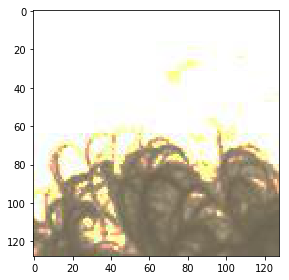

In [6]:
io.imshow(img)

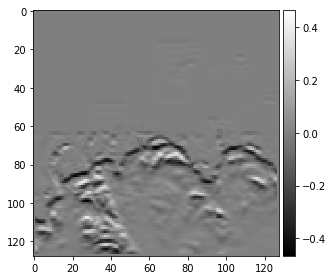

In [8]:
from skimage.filters import prewitt_h,prewitt_v

edges_prewitt_horizontal = prewitt_h(np.squeeze(img[:,:,0]))
# calculating vertical edges using prewitt kernel
# edges_prewitt_vertical = prewitt_v(img)

io.imshow(edges_prewitt_horizontal, cmap='gray')

### extract features

Relative length, Relative area, Mean, Standard
deviation, Entropy, Eccentricity and length to width ratio

--- http://www.ipcsit.com/vol4/12-ICINT2011T052.pdf


Global Feature Descriptors
These are the feature descriptors that quantifies an image globally. These don’t have the concept of interest points and thus, takes in the entire image for processing. Some of the commonly used global feature descriptors are

Color - Color Channel Statistics (Mean, Standard Deviation) and Color Histogram
Shape - Hu Moments, Zernike Moments
Texture - Haralick Texture, Local Binary Patterns (LBP)
Others - Histogram of Oriented Gradients (HOG), Threshold Adjancency Statistics (TAS)
Local Feature Descriptors
These are the feature descriptors that quantifies local regions of an image. Interest points are determined in the entire image and image patches/regions surrounding those interest points are considered for analysis. Some of the commonly used local feature descriptors are

SIFT (Scale Invariant Feature Transform)
SURF (Speeded Up Robust Features)
ORB (Oriented Fast and Rotated BRIEF)
BRIEF (Binary Robust Independed Elementary Features)
Combining Global Features
There are two popular ways to combine these feature vectors.

For global feature vectors, we just concatenate each feature vector to form a single global feature vector. This is the approach we will be using in this tutorial.
For local feature vectors as well as combination of global and local feature vectors, we need something called as Bag of Visual Words (BOVW). This approach is not discussed in this tutorial, but there are lots of resources to learn this technique. Normally, it uses Vocabulory builder, K-Means clustering, Linear SVM, and Td-Idf vectorization.

https://gogul.dev/software/image-classification-python#feature-extraction

#### Global features

In [9]:
# feature-descriptor-1: Hu Moments, which quantifies shape
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [10]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

In [11]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir_class = os.path.join(train_dir, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for each_img in os.listdir(dir_class):
        if each_img == '.DS_Store':
            continue
        # get the image file name
        file = dir_class + "/" + each_img

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)

        # Global Feature extraction
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)

        # Concatenate global features
        global_feature = np.hstack([fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: 1
[STATUS] processed folder: 2
[STATUS] processed folder: 3
[STATUS] processed folder: 4
[STATUS] processed folder: 5
[STATUS] processed folder: 6
[STATUS] processed folder: 7
[STATUS] processed folder: 8
[STATUS] completed Global Feature Extraction...


In [12]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data_train = h5py.File(h5_data_train, 'w')
h5f_data_train.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label_train = h5py.File(h5_labels_train, 'w')
h5f_label_train.create_dataset('dataset_1', data=np.array(target))

h5f_data_train.close()
h5f_label_train.close()

print("[STATUS] end of training..")

[STATUS] feature vector size (3808, 20)
[STATUS] training Labels (3808,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 ... 7 7 7]
[STATUS] target labels shape: (3808,)
[STATUS] end of training..


## Train classifier

In [13]:
num_trees = 100
test_size = 0.10
seed      = 9

scoring    = "accuracy"

In [14]:
# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []


In [29]:
# import the feature vector and trained labels
h5f_data_train  = h5py.File(h5_data_train, 'r')
h5f_label_train = h5py.File(h5_labels_train, 'r')

global_features_string = h5f_data_train['dataset_1']
global_labels_string   = h5f_label_train['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data_train.close()
h5f_label_train.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (3808, 20)
[STATUS] labels shape: (3808,)
[STATUS] training started...


### if we want to do 10-fold cross validation

In [ ]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

In [ ]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

### if we use preclassified train&validation set

In [22]:
# loop over validation set
val_labels = []
val_features = []


for training_name in train_labels:
    # join the training data path and each species training folder
    dir_class = os.path.join(valid_dir, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for each_img in os.listdir(dir_class):
        if each_img == '.DS_Store':
            continue
        # get the image file name
        file = dir_class + "/" + each_img

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)

        # Global Feature extraction
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)

        # Concatenate global features
        global_feature = np.hstack([fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        val_labels.append(current_label)
        val_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: 1
[STATUS] processed folder: 2
[STATUS] processed folder: 3
[STATUS] processed folder: 4
[STATUS] processed folder: 5
[STATUS] processed folder: 6
[STATUS] processed folder: 7
[STATUS] processed folder: 8
[STATUS] completed Global Feature Extraction...


In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features_val = scaler.fit_transform(val_features)       


In [47]:
# try all methods
for name, model in models:
    model.fit(global_features, global_labels)
    val_pred = model.predict(rescaled_features_val)
    val_pred_label = [train_labels[tmp] for tmp in val_pred]
    balanced_accuracy = balanced_accuracy_score(val_labels, val_pred_label)
    
    names.append(name)
    msg = "%s: %f" % (name, balanced_accuracy)
    print(msg)

LR: 0.516405
LDA: 0.602846
KNN: 0.663737
CART: 0.624130
RF: 0.680603
NB: 0.403091
SVM: 0.398729


In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [48]:
# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(global_features, global_labels)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=9, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(testDataGlobal)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(testLabelsGlobal, pred)

### Test on best classifier

In [39]:
# loop through the test images
test_labels = []
test_features = []

for testing_name in train_labels:
    # join the training data path and each species training folder
    dir_class = os.path.join(test_dir, testing_name)

    # get the current training label
    current_label = testing_name

    # loop over the images in each sub-folder
    for each_img in os.listdir(dir_class):
        if each_img == '.DS_Store':
            continue
        # get the image file name
        file = dir_class + "/" + each_img

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        
        global_feature = np.hstack([fv_haralick, fv_hu_moments])
        
        test_labels.append(current_label)
        test_features.append(global_feature)

scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(test_features)       
        


In [49]:
test_pred = clf.predict(rescaled_features)
test_pred_label = [train_labels[tmp] for tmp in test_pred]

In [50]:
accuracy_score(test_labels, test_pred_label)

0.7312572087658593

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, test_pred_label)

In [51]:
balanced_accuracy_score(test_labels, test_pred_label)

0.4948217235218806

In [ ]:
accuracy_score(test_labels, test_pred_label)